> __Код делал в Google Colab, тк некотоыре функции arviz и pymc из интернета, которые хотел применить к решению не работали в ноутбуке. В колабе все работает без ошибок!__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

from sklearn.metrics import accuracy_score

sns.set_style("whitegrid")
print("Running on PyMC v{}".format(pm.__version__))

Running on PyMC v5.7.2


# **TASK 1**

In [3]:
train_data = pd.read_csv('classify/train_clf.csv')
test_data = pd.read_csv('classify/test_clf.csv')

In [4]:
columns = train_data.columns[:-1]
x_o = train_data[columns].values
x_means = x_o.mean(axis=0)
x_1 = (x_o - x_means)/x_o.std()

y_1 = [1 if marker == 1.0 else 0 for marker in train_data.y]

In [5]:
# у нас наблюдается баланс классов, следовательно можно будет использовать accuracy
train_data.y.value_counts()

y
1.0    51
0.0    49
Name: count, dtype: int64

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'c'}>, <Axes: >]], dtype=object)

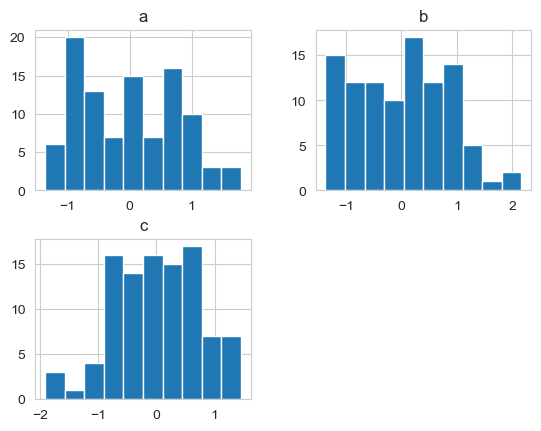

In [6]:
pd.DataFrame(x_1,columns = columns).hist()

/Users/imachome/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/imachome/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/imachome/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/imachome/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

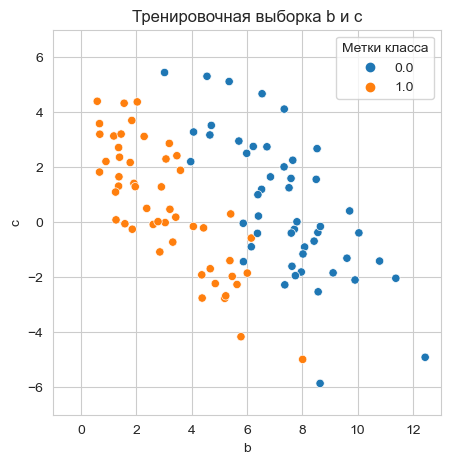

In [7]:
_, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(x="b", y="c", data=train_data, hue="y")
ax.legend(title='Метки класса')
ax.set(title="Тренировочная выборка b и c", xlim=(-1, 13), ylim=(-7, 7));

In [8]:
#train_data.describe();

In [9]:
# sns.pairplot(train_data);

In [10]:
# train_data.hist(figsize=(5, 5));

In [11]:
with pm.Model() as model_1:

    α_tmp = pm.Normal('α_tmp', mu=0, sigma=5)
    β = pm.Normal('β', mu=0, sigma=2, shape=len(columns))

    μ = α_tmp + pm.math.dot(x_1, β)
    θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
    α = pm.Deterministic('α', α_tmp - pm.math.dot(β,x_means))
    bd = pm.Deterministic('bd', -α/β[1] - β[0]/β[1] * (x_1[:,0]+x_means[0]))

    yl = pm.Bernoulli('yl', p=θ, observed=y_1)

    trace_1 = pm.sample(1000, chains = 4, cores = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

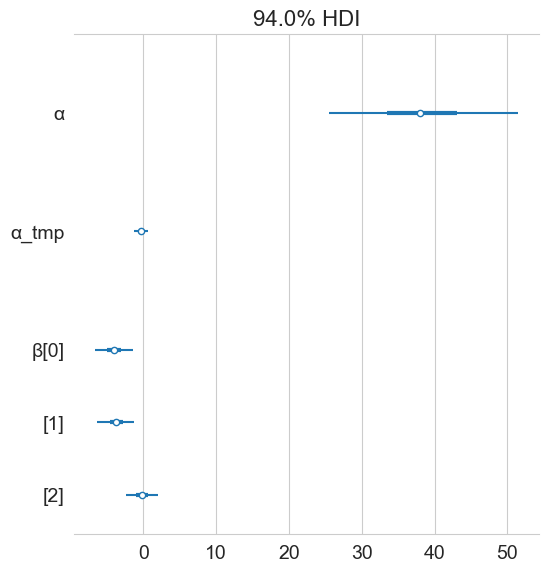

In [12]:
az.plot_forest(trace_1, var_names=['α','α_tmp', 'β'], combined=True)

In [13]:
az.summary(trace_1, var_names=['α_tmp','α', 'β'])
# можно увидеть,что β при 3 признаке по сравнению с другими достаточно маленькая => можно предположить, что признак
# для модели является неинформативным и не дает особого буста в объяснение дисперсии целевой переменной
# можно будет построить регрессию без этого, как вариант

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_tmp,-0.279,0.489,-1.232,0.593,0.008,0.007,3449.0,2877.0,1.0
α,38.480,7.147,25.487,51.457,0.127,0.093,3270.0,2591.0,1.0
β[0],-4.050,1.374,-6.607,-1.407,0.030,0.021,2101.0,2499.0,1.0
β[1],-3.746,1.337,-6.332,-1.250,0.032,0.023,1746.0,2561.0,1.0
β[2],-0.217,1.188,-2.376,2.054,0.028,0.020,1814.0,2181.0,1.0


array([[<Axes: ylabel='α'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='β\n0'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='β\n1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='α_tmp', ylabel='β\n2'>, <Axes: xlabel='α'>,
        <Axes: xlabel='β\n0'>, <Axes: xlabel='β\n1'>]], dtype=object)

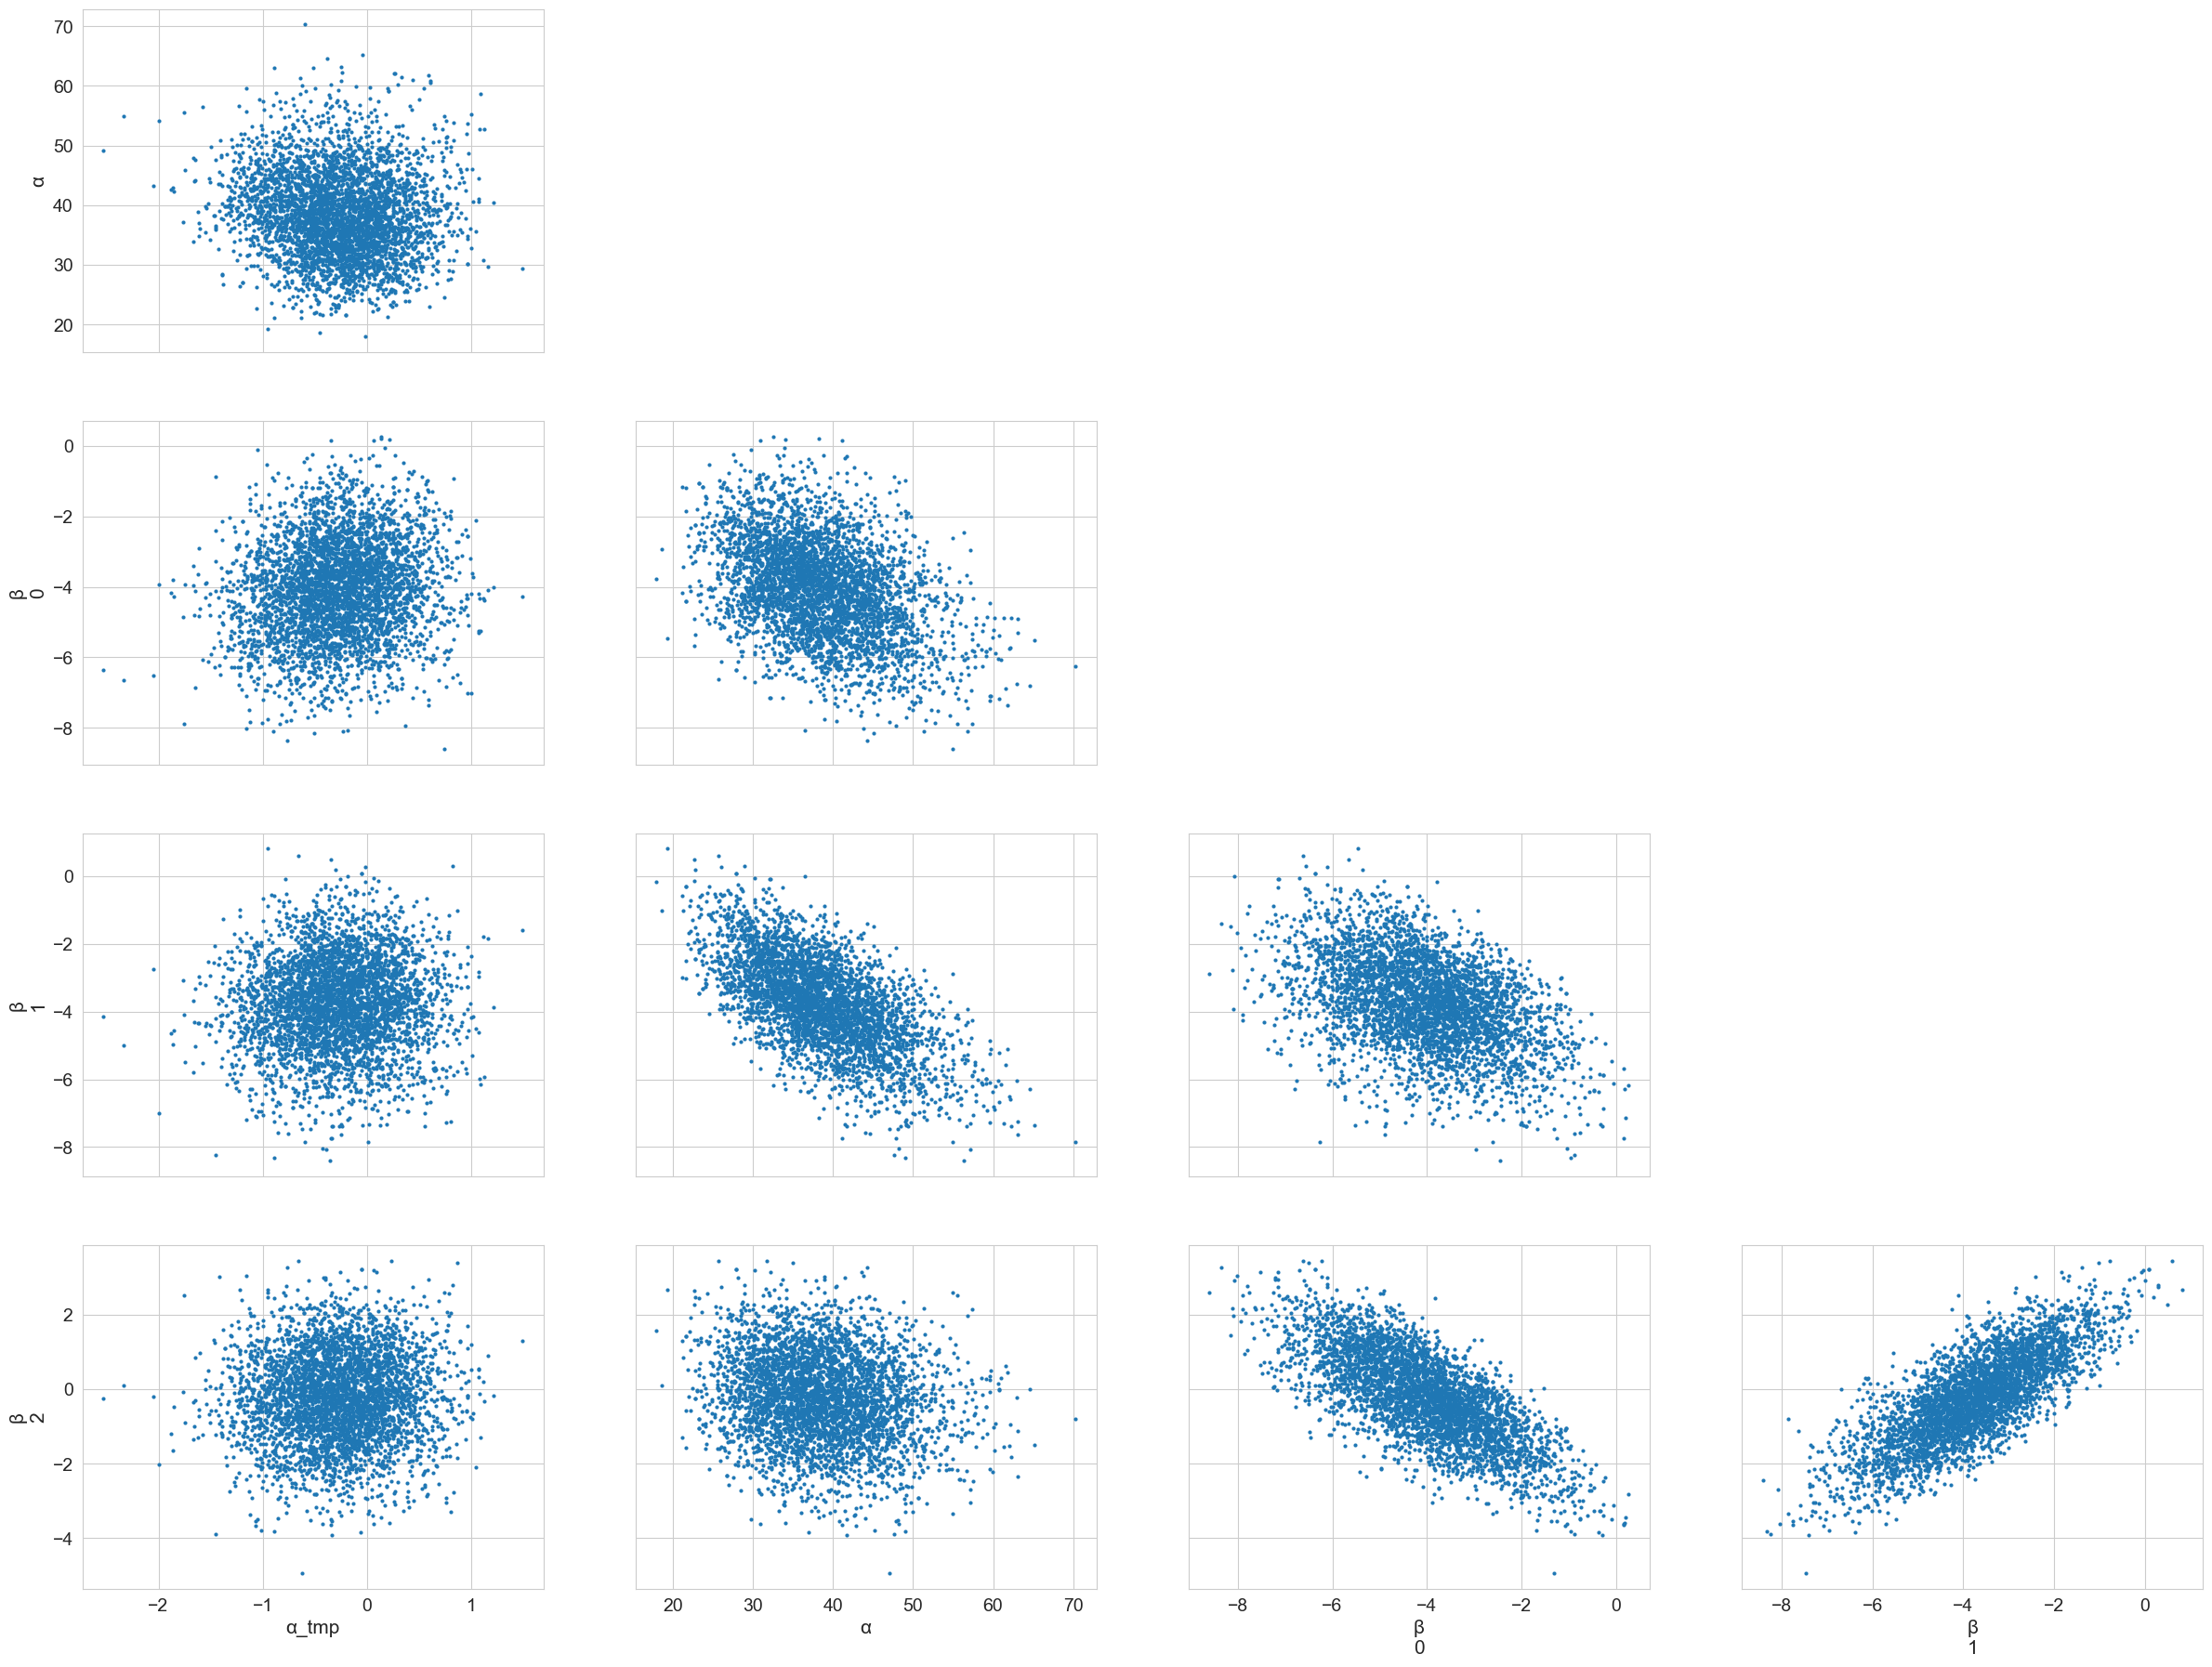

In [14]:
az.plot_pair(trace_1, var_names=['α_tmp','α', 'β'])

array([[<Axes: title={'center': 'α_tmp'}>,
        <Axes: title={'center': 'α_tmp'}>],
       [<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>],
       [<Axes: title={'center': 'β\n0'}>,
        <Axes: title={'center': 'β\n0'}>],
       [<Axes: title={'center': 'β\n1'}>,
        <Axes: title={'center': 'β\n1'}>],
       [<Axes: title={'center': 'β\n2'}>,
        <Axes: title={'center': 'β\n2'}>]], dtype=object)

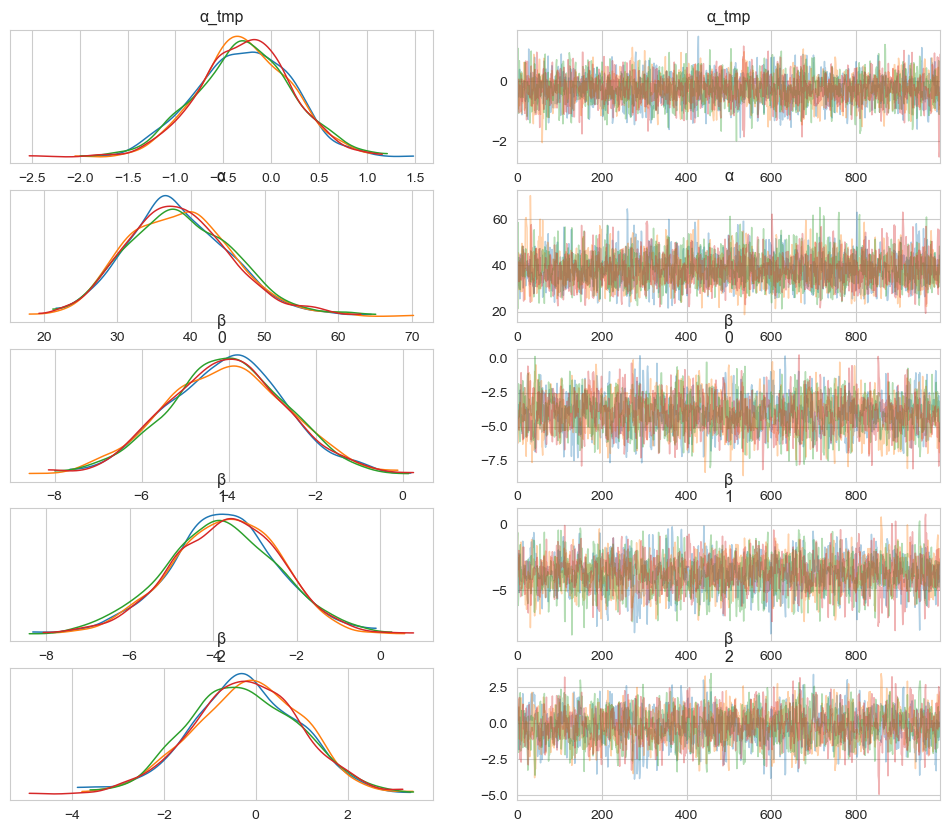

In [15]:
az.plot_trace(trace_1, var_names = ['α_tmp','α','β'], compact=False)

array([[<Axes: title={'center': 'α\n0'}>,
        <Axes: title={'center': 'α\n1'}>,
        <Axes: title={'center': 'α\n2'}>,
        <Axes: title={'center': 'α\n3'}>],
       [<Axes: title={'center': 'β\n0, 0'}>,
        <Axes: title={'center': 'β\n0, 1'}>,
        <Axes: title={'center': 'β\n0, 2'}>,
        <Axes: title={'center': 'β\n1, 0'}>],
       [<Axes: title={'center': 'β\n1, 1'}>,
        <Axes: title={'center': 'β\n1, 2'}>,
        <Axes: title={'center': 'β\n2, 0'}>,
        <Axes: title={'center': 'β\n2, 1'}>],
       [<Axes: title={'center': 'β\n2, 2'}>,
        <Axes: title={'center': 'β\n3, 0'}>,
        <Axes: title={'center': 'β\n3, 1'}>,
        <Axes: title={'center': 'β\n3, 2'}>]], dtype=object)

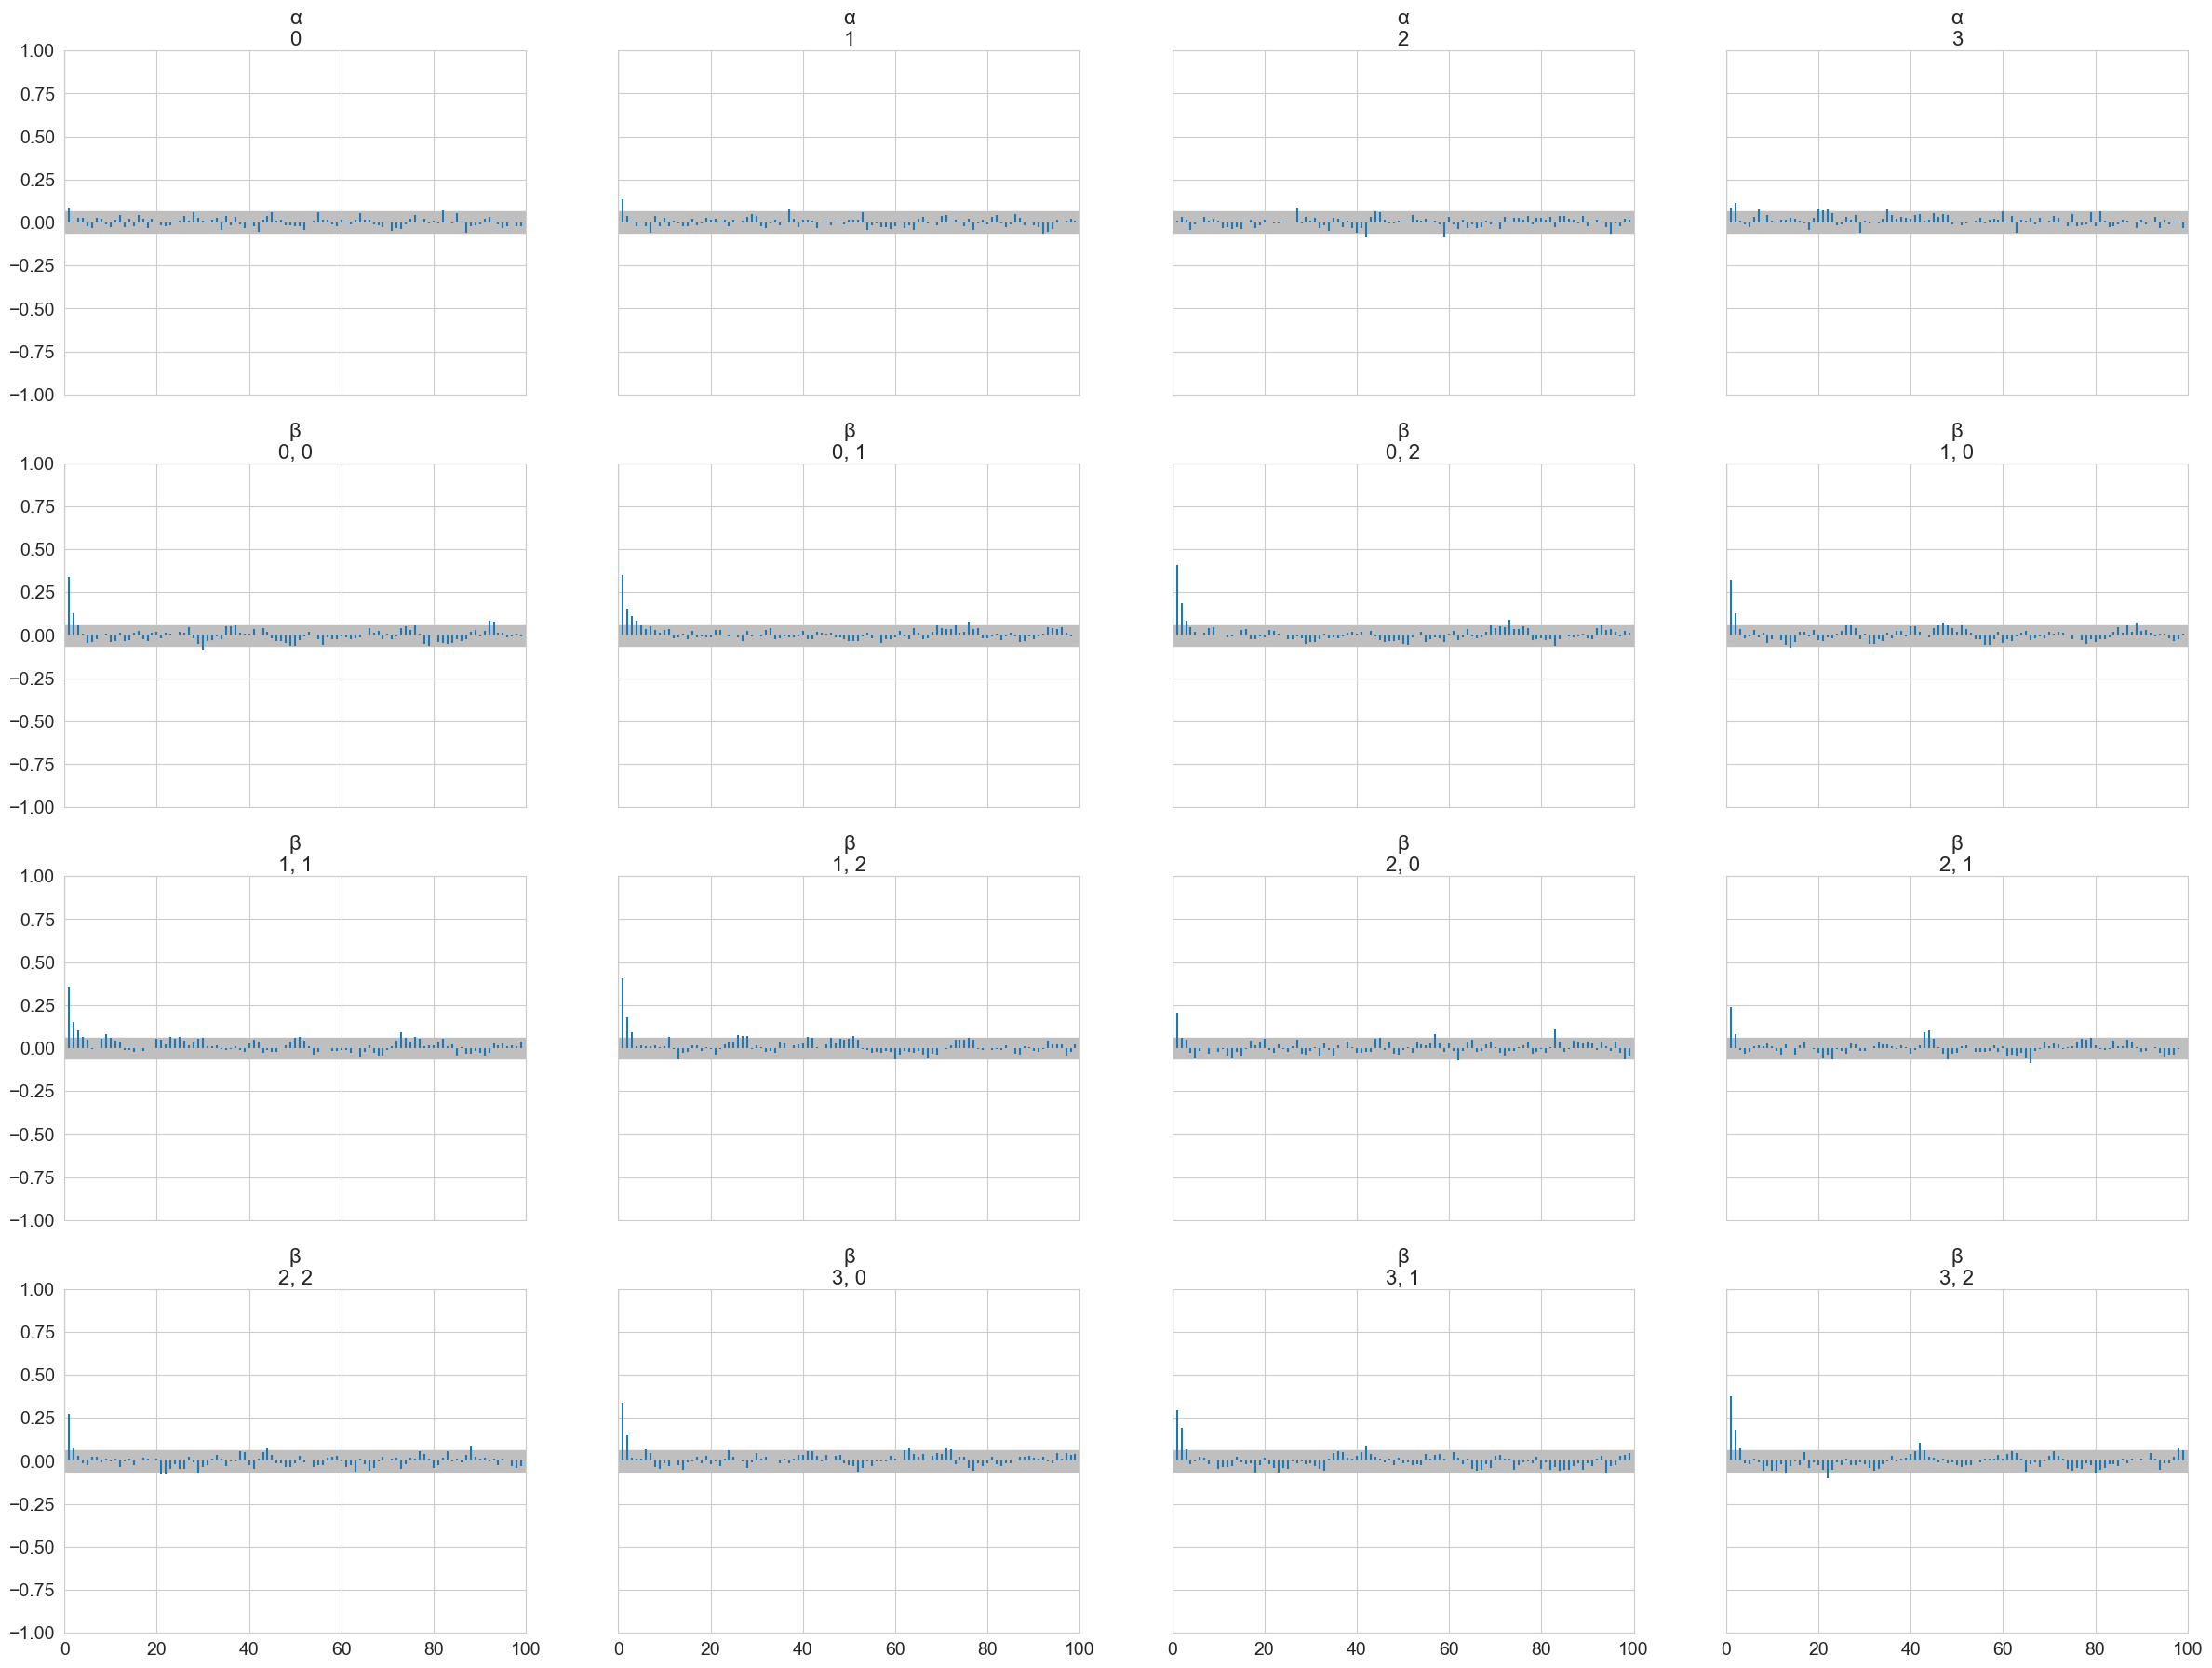

In [16]:
az.plot_autocorr(trace_1, ['α', 'β'])
# Видно, что сильных выбросов нету, которые выходят за интервал
# В самом начале есть выходы за диапазон, но это однократно и на лекции были такие же случаи

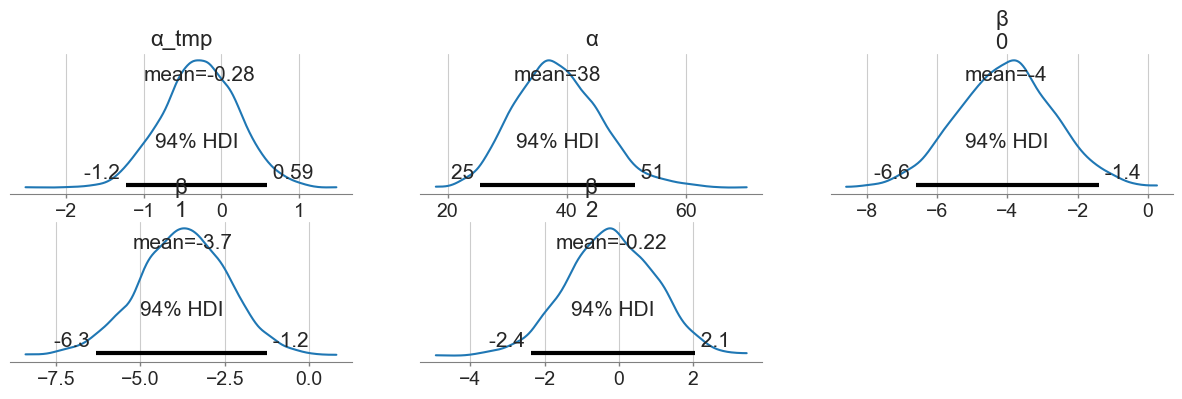

In [17]:
# Посмотрим на распределения наших оценок, с доверительными интервалами
az.plot_posterior(trace_1, var_names=['α_tmp','α', 'β'], figsize=(15, 4) );

In [18]:
y_pred_tr = [teta.mean() for teta in trace_1.posterior['θ'].mean(axis= 0).T]
y_pred_train = [1 if proba >= 0.5 else 0 for proba in y_pred_tr]
print('Accuracy: {metric}'.format(metric = accuracy_score(y_1,y_pred_train)))

Accuracy: 0.96


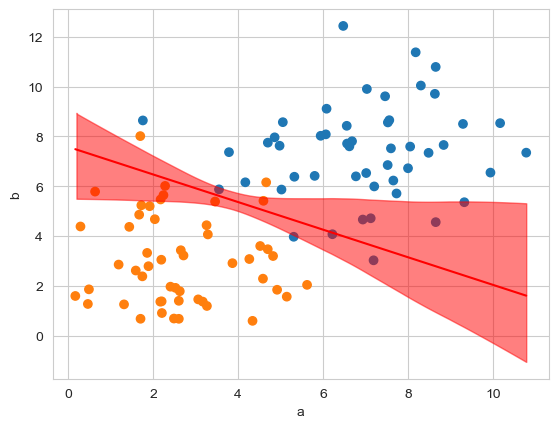

In [19]:
idx = np.argsort(x_1[:,0])
bd = trace_1.posterior['bd'].mean(("chain", "draw"))[idx]

plt.scatter(x_o[:,0], x_o[:,1], c=[f'C{i}' for i in y_1])

plt.plot(x_o[:,0][idx], bd, color='r');
az.plot_hdi(x_o[:,0], trace_1.posterior['bd'], color='r')

plt.xlabel(columns[0]);

plt.ylabel(columns[1]);

In [20]:
x_test = test_data.values
x_test_mean = x_test.mean(axis=0)
x_test_c = (x_test - x_test.mean())/ x_test.std()

In [21]:
test_data.describe()

,a,b,c
count,100.000000,100.000000,100.000000
mean,4.659825,4.847100,0.839002
std,2.493834,2.691307,2.474297
min,0.596895,0.343986,-4.697342
25%,2.643445,2.718368,-0.903236
50%,4.513813,4.572929,0.957872
75%,6.848342,6.918697,2.339878
max,10.731549,11.926484,6.131869


array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'c'}>, <Axes: >]], dtype=object)

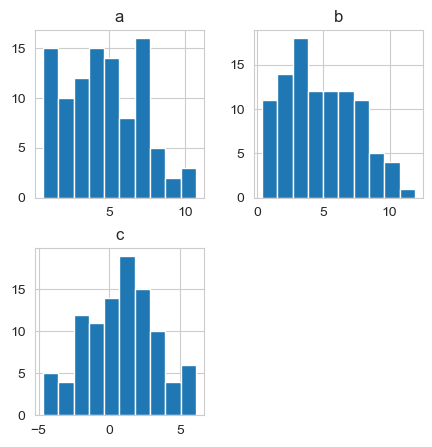

In [22]:
test_data.hist(figsize=(5,5))

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'b'}>],
       [<Axes: title={'center': 'c'}>, <Axes: >]], dtype=object)

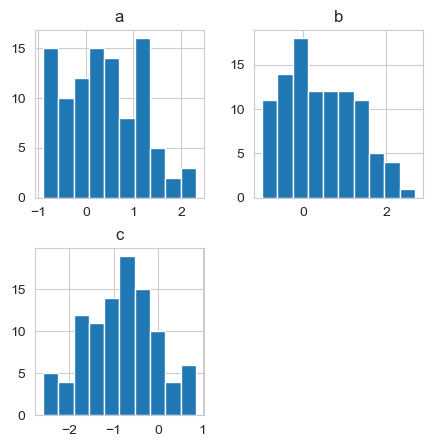

In [23]:
pd.DataFrame(x_test_c, columns = columns).hist(figsize=(5,5))

In [24]:
# 1 вариант решения, который можно подсмотреть
# здесь https://www.pymc.io/projects/examples/en/latest/howto/data_container.html#data_container
# данный кусок не выполнялся в ноутбуке, поэтому перешел в колаб
# Не знаю можно ли такое использовать, тк pymc3 такое реализуется для предсказаний, а вот используя pymc2 не знаю, но работает
# если такое использовать не разрешено, то дальше есть 2 вариант решения
# иначе, думаю, что брать лучше ответ от сюда, тк генерируется много значений, которые пытаются описать целевую переменную
# возможно, что эти ответы будут ближе к y_true

with model_1:

    x_test = pm.Data('x_test', x_test_c)

    μ_test = α_tmp + pm.math.dot(x_test, β)

    θ_test = pm.math.sigmoid(μ_test)

    ppc_test = pm.sample_posterior_predictive(trace_1, var_names = ['θ'])

/Users/imachome/anaconda3/lib/python3.11/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Sampling: []


In [25]:
y_pred_massiv = ppc_test.posterior_predictive['θ'].values.T

In [26]:
y_pred_test_ppc = [y_pred_massiv[idx].mean() for idx in range(y_pred_massiv.shape[0])]

In [27]:
# Внутри сравниваем вероятности с трешхолдом и получает на выход дискретные величины
y_pred = [1 if proba >= 0.5 else 0 for proba in y_pred_test_ppc]

In [28]:
# 2 способ решения: построить самостоятельно модель и сделать предсказания таким образом:
α_coef_tmp = trace_1.posterior['α_tmp'].mean(("chain", "draw")).values
β1_coef = trace_1.posterior['β'].mean(axis=0).mean(axis=0)[0].item()
β2_coef = trace_1.posterior['β'].mean(axis=0).mean(axis=0)[1].item()

μ = α_coef_tmp + β1_coef * x_test_c[:,0] +  β2_coef * x_test_c[:,0]

In [29]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [30]:
y_pred_proba = [sigmoid(z) for z in μ]

In [31]:
y_pred_test = [1 if proba >= 0.5 else 0 for proba in y_pred_proba]

In [36]:
# Предсказанные классы, оба массива с предсказаниями совпадают, поэтому можно взять любой
# Если разрешено делать 1 способом, то лучше взять 1, если нет, то 2
y_pred # 1 вариант
y_pred_test # 2 вариант
print(y_pred_test)

[0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]


In [33]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_pred)

0.46

In [34]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_pred_test)

0.84

In [37]:
(0.46+0.84)/2

0.65

# **TASK 2**

In [38]:
# Загружаем и стандартизируем наши данные
# Можно было бы воспользоваться StanderScaler, но сделаем ручным образом наше преобразование
X_train = train_data[columns].values
X_train  = (X_train - X_train.mean())/ X_train.std()
X_test = (test_data.values - test_data.values.mean())/ test_data.values.std()
y_train = train_data.y.values

In [39]:
def generative_model(X_train, y_train, value):
    with pm.Model() as lda:
        μ = pm.Normal('μ', mu=0, sigma=10, shape=2)
        features = pm.Normal('features', mu=μ, sigma=0.65, observed=X_train[y_train == value][:, [0, 1]])
        trace_gener = pm.sample(1000, chains=4, cores=4)

    μ_values = trace_gener.posterior['μ'].mean(axis=0).mean(axis=0)

    return μ_values

μ_1 = generative_model(X_train, y_train, 0)
μ_2 = generative_model(X_train, y_train, 1)

μ_11, μ_12 = μ_1[0].item(), μ_1[1].item()
μ_21, μ_22 = μ_2[0].item(), μ_2[1].item()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


In [40]:
# Предсказание тренировочных данных
y_train_pred_gen_model = [0 if (i[0] - μ_11)**2 + (i[1] - μ_12)**2 < (i[0] - μ_21)**2 + (i[1] - μ_22)**2 else 1 for i in X_train]


In [41]:
accuracy = accuracy_score(y_train, y_train_pred_gen_model)
print("Accuracy:", accuracy)
# Видим, что на тренировочной выборке у нас увеличилось до 0.97

Accuracy: 0.96


In [42]:
# Делаем предсказание тестовых данных
y_test_pred_gen_model = np.array([0 if (i[0] - μ_11) ** 2 + (i[1] - μ_12) ** 2 < (i[0] - μ_21) ** 2 + (i[1] - μ_22) ** 2 else 1 for i in X_test])
y_test_pred_gen_model

array([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1])

In [43]:
from sklearn.metrics import accuracy_score
y_true = pd.read_csv('test_Y_true_clf.csv')
accuracy_score(y_true, y_test_pred_gen_model)

0.96